In [50]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imp
import lightgbm as lgb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import time
from datetime import date, timedelta
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from scipy.stats import poisson
import scipy.stats as stats
%matplotlib inline

from google.oauth2.service_account import Credentials
import google_auth_httplib2
import pygsheets
import df2gspread as d2g
import googleapiclient
from googleapiclient  import discovery
from httplib2 import Http
from oauth2client import file, client, tools
from gspread_formatting.dataframe import format_with_dataframe, BasicFormatter
from gspread_formatting import Color
import logging

from oauth2client.service_account import ServiceAccountCredentials
from google.oauth2 import service_account
import gslides
from gslides import (Frame,Presentation,Spreadsheet,Table,Series,Chart)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import sqlalchemy as db
from sqlalchemy import create_engine
import mysql.connector
import psycopg2
from prophet import Prophet

In [39]:
train = pd.read_csv('C:/Users/leemn/Downloads/train_store_items.csv')
test = pd.read_csv('C:/Users/leemn/Downloads/test_store_items.csv')
train_df = pd.concat([train, test], sort=False)

In [4]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [9]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [40]:
train.shape, test.shape, train_df.shape

((913000, 4), (45000, 4), (958000, 5))

In [42]:
print(train['store'].nunique())
print(train['item'].nunique())
print(train_df['item'].nunique())
print(train_df['store'].nunique())

10
50
50
10


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [43]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
train_df['date'] = pd.to_datetime(train_df['date'])

In [11]:
print("The data has sales from {} to {}".format(min(train['date']),
                                                 max(train['date'])))

The data has sales from 2013-01-01 00:00:00 to 2017-12-31 00:00:00


In [44]:
train['date'].min(), train['date'].max(),test['date'].min(), test['date'].max(), train_df['date'].min(), train_df['date'].max()

(Timestamp('2013-01-01 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-03-31 00:00:00'),
 Timestamp('2013-01-01 00:00:00'),
 Timestamp('2018-03-31 00:00:00'))

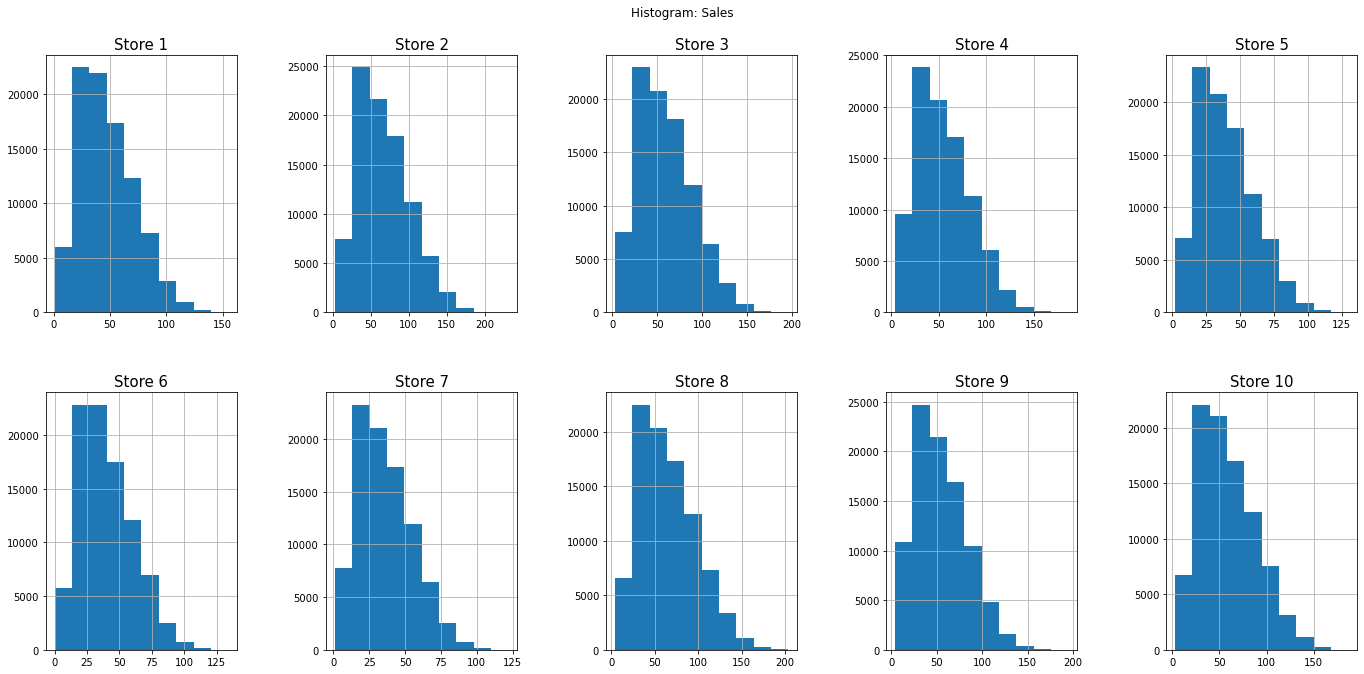

In [18]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i in range(1,11):
    if i < 6:
        train[train.store == i].sales.hist(ax=axes[0, i-1])
        axes[0,i-1].set_title("Store " + str(i), fontsize = 15)
        
    else:
        train[train.store == i].sales.hist(ax=axes[1, i - 6])
        axes[1,i-6].set_title("Store " + str(i), fontsize = 15)
plt.tight_layout(pad=4.5)
plt.suptitle("Histogram: Sales");

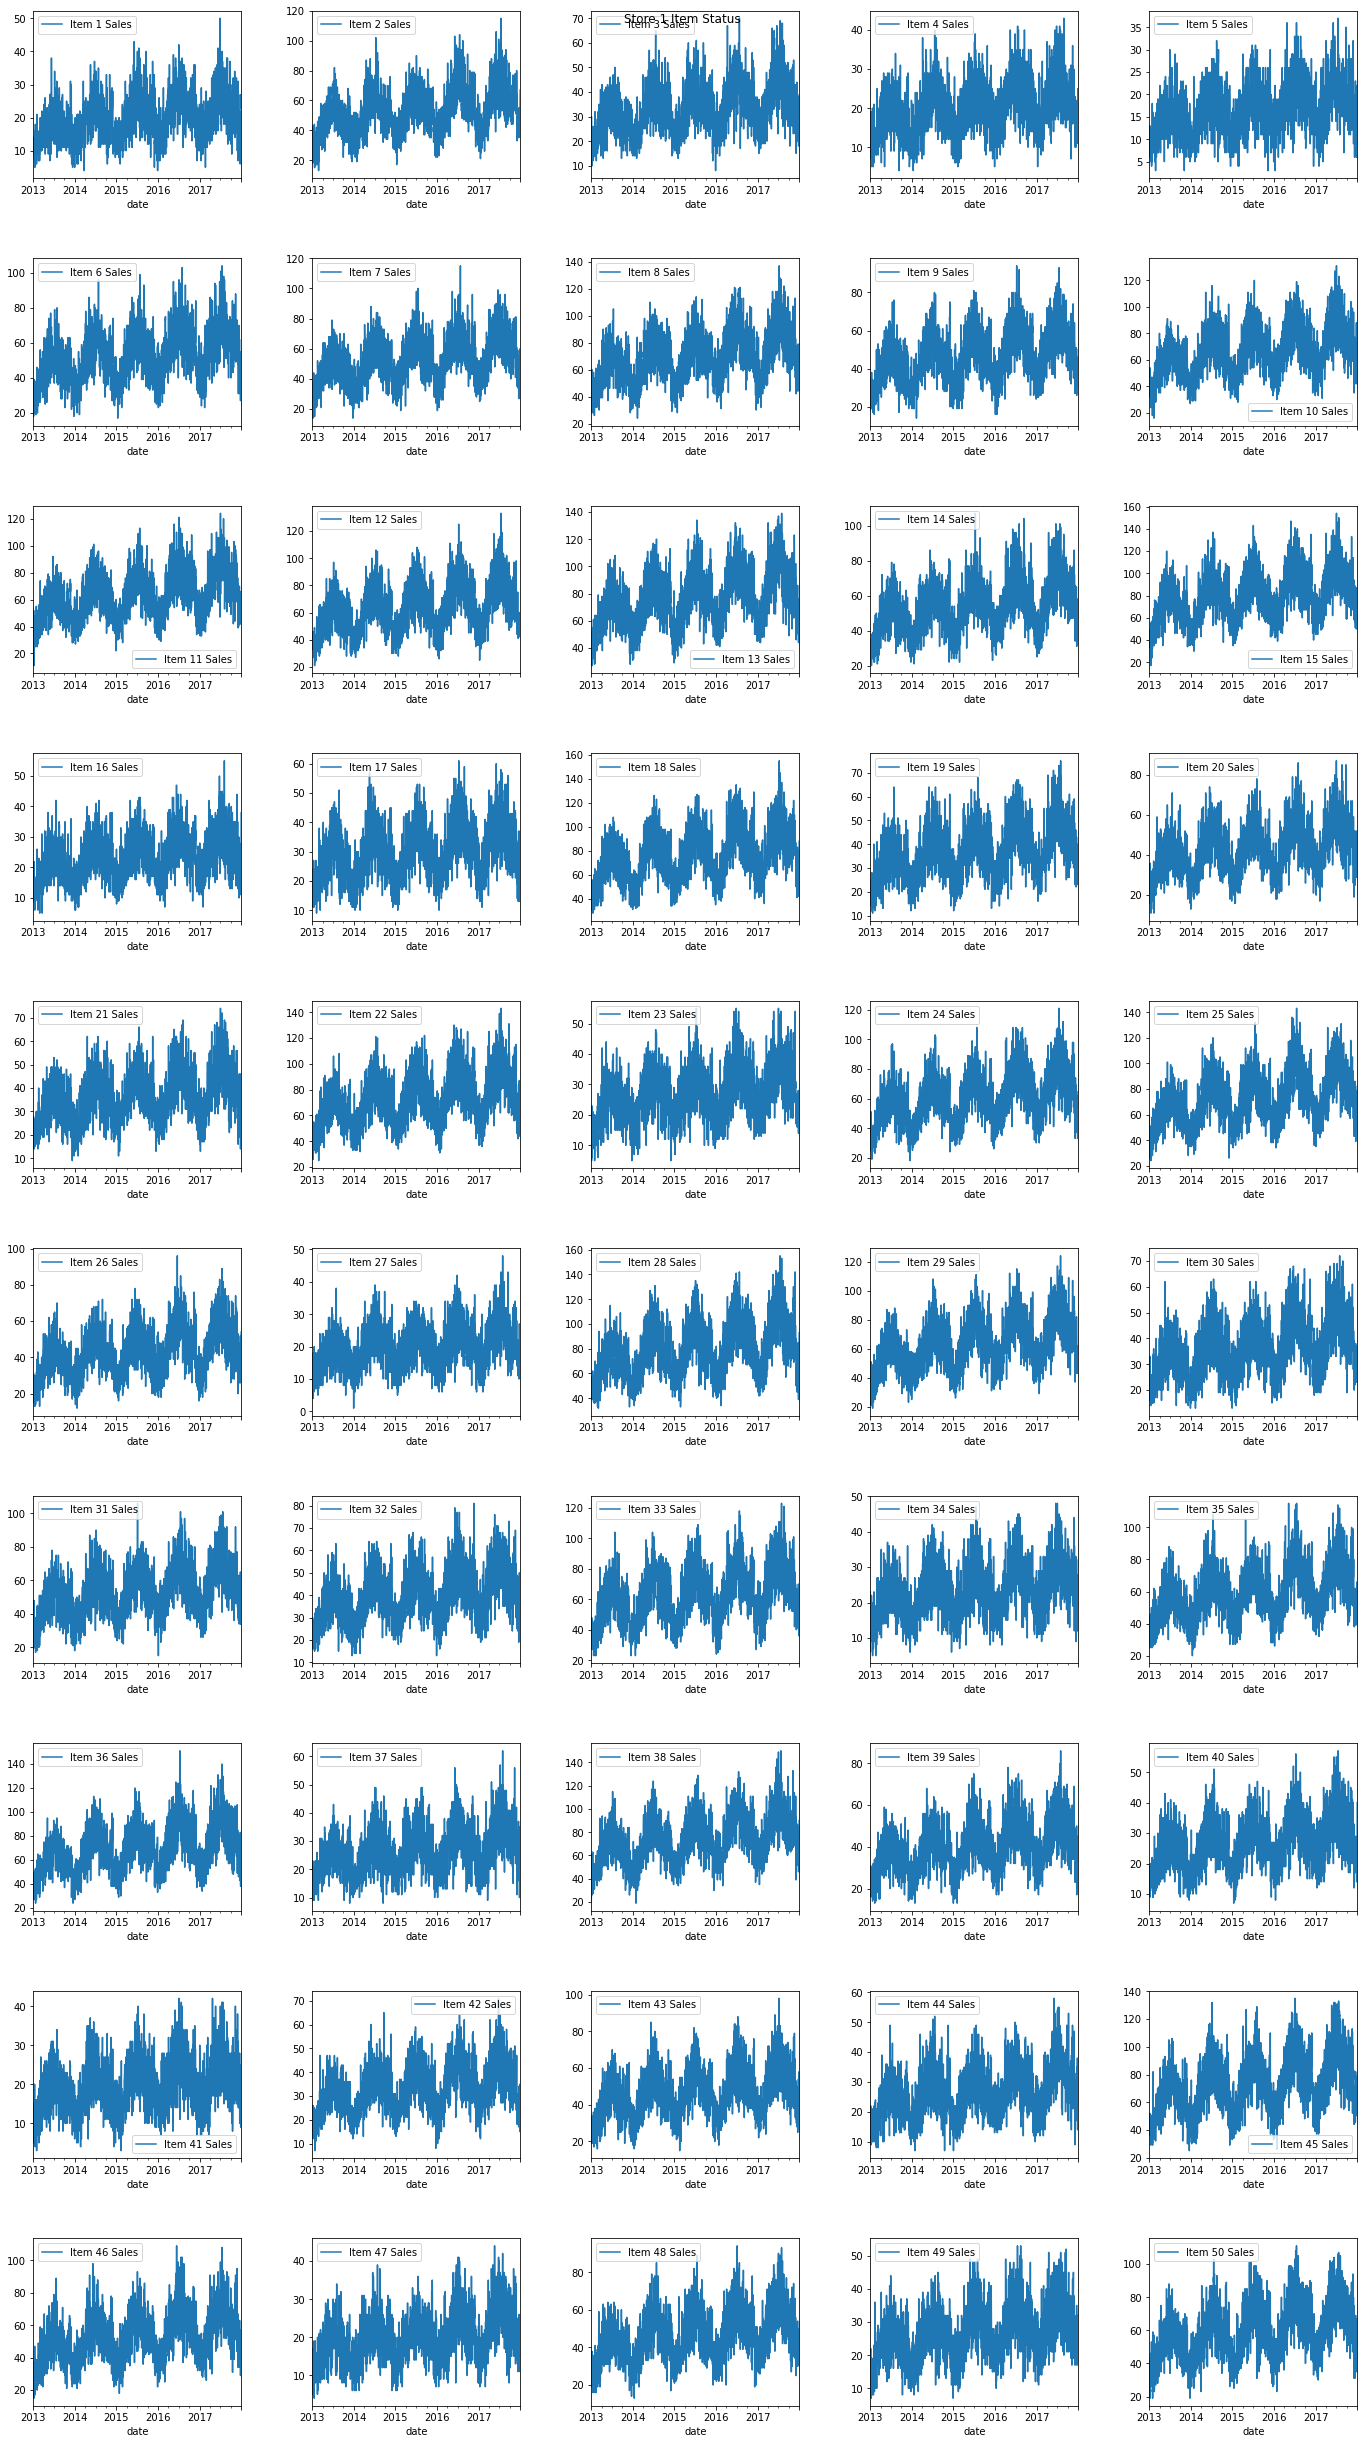

In [19]:
store = 1
sub = train[train.store == store].set_index("date")

fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 6 and i<11:
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
    if i >= 11 and i<16:
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 16 and i<21:
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 21 and i<26:
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales")  
    if i >= 26 and i<31:
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 31 and i<36:
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 36 and i<41:
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")    
    if i >= 41 and i<46:
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales") 
    if i >= 46 and i<51:
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales") 
plt.tight_layout(pad=4.5)
plt.suptitle("Store 1 Item Status");

## Feature Engineering

In [45]:
# Date features

def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df['is_wknd'] = df.date.dt.weekday // 4  # Also included Friday as weekend
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['quarter'] = df.date.dt.quarter
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)
    df['is_christmas_week'] = (df.date.dt.weekofyear == 51).astype(int)
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    return df

train_df = create_date_features(train_df)
train_df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_christmas_week,season
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,1,1,0,0,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,1,0,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,1,0,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,1,0,0,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,1,0,0,0,0


## Cost Function

In [46]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(y_true, y_pred):
    smape_val = smape(y_true, y_pred)
    return 'SMAPE', smape_val, False

In [47]:
# Split data

# Validation set includes 3 months (Oct. Nov. Dec. 2017)
train = train_df.loc[(train_df['date']<'2017-10-01'), :]
val = train_df.loc[(train_df['date']>='2017-10-01') & (train_df['date']<'2018-01-01'), :]

print(train.shape)
print(val.shape)

# Remove cols as features are generated from them
cols = [col for col in train_df.columns if col not in ['date','id','sales','year']]

(867000, 19)
(46000, 19)


In [48]:
y_train = train_df['sales']
X_train = train_df[cols]

y_val = val['sales']
X_val = val[cols]

y_train.shape, X_train.shape, y_val.shape, X_val.shape

((958000,), (958000, 15), (46000,), (46000, 15))

In [51]:
# Light GMB
lgb = lgb.LGBMRegressor(random_state=384).fit(X_train, y_train, 
                                                      eval_metric= lambda y_true, y_pred: [lgbm_smape(y_true, y_pred)])

print("TRAIN SMAPE:", smape(y_train, lgb.predict(X_train)))
print("VALID SMAPE:", smape(y_val, lgb.predict(X_val)))

TRAIN SMAPE: 16.5615515999664
VALID SMAPE: 16.122043421968968


In [52]:
# Feature importance

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

feature_imp_df = plot_lgb_importances(lgb, num=50)

              feature  split       gain
1                item   1753  59.004465
0               store    403  14.045655
4         day_of_year    251   7.991217
14             season     32   7.056156
6         day_of_week    167   5.550290
2               month     91   3.137679
5        week_of_year    116   2.010845
3        day_of_month    166   0.968804
7             is_wknd      3   0.191496
11   is_quarter_start     13   0.034552
12     is_quarter_end      5   0.008841
8      is_month_start      0   0.000000
9        is_month_end      0   0.000000
10            quarter      0   0.000000
13  is_christmas_week      0   0.000000


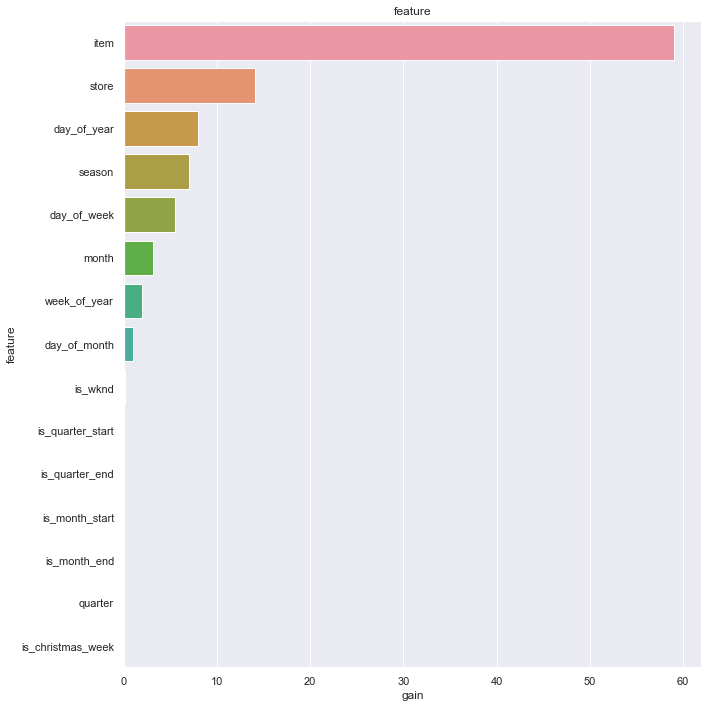

In [53]:
plot_lgb_importances(lgb, plot=True, num=30)

In [54]:
## Model Error 
error = pd.DataFrame({
    "date":val.date,
    "store":X_val.store,
    "item":X_val.item,
    "actual":Y_val,
    "pred":lgb.predict(X_val)
}).reset_index(drop = True)

error["error"] = np.abs(error.actual-error.pred)

error.sort_values("error", ascending=False).head(20)

,date,store,item,actual,pred,error
22759,2017-11-05,8,25,168,111.164432,56.835568
20019,2017-11-25,8,22,165,109.133037,55.866963
24987,2017-11-25,2,28,173,119.036098,53.963902
13026,2017-11-24,2,15,168,114.860556,53.139444
24895,2017-11-25,1,28,142,90.211946,51.788054
13748,2017-11-10,10,15,154,102.979285,51.020715
32304,2017-10-13,2,36,150,99.237007,50.762993
24974,2017-11-12,2,28,173,122.319317,50.680683
32327,2017-11-05,2,36,163,112.435599,50.564401
7132,2017-11-18,8,8,152,102.043744,49.956256


In [55]:
# Mean Absolute Error
error.groupby(["store"]).error.mean().sort_values(ascending = False)

store
2     10.859601
8     10.379229
3      9.068485
10     8.851251
4      8.586892
9      8.027749
1      6.924368
5      6.282779
6      6.242458
7      5.702193
Name: error, dtype: float64

In [56]:
# Mean Absolute Error
error.groupby(["item"]).error.mean().sort_values(ascending = False)

item
28    14.181073
38    13.465784
13    13.362118
45    13.305028
36    12.920332
25    12.683498
22    12.639579
15    12.626896
18    12.476680
8     12.127941
10    10.734728
29    10.183851
33    10.160420
11     9.817497
24     9.612954
50     9.460812
43     9.439938
12     9.072954
31     8.957742
2      8.786289
35     8.717806
46     8.685014
48     8.219091
7      8.177433
6      7.993834
20     7.868653
14     7.220788
26     7.031714
39     6.919572
9      6.336502
32     6.223056
3      6.125502
30     5.939714
21     5.672283
19     5.667426
42     5.652615
17     5.340676
40     5.308567
27     5.171244
23     5.159625
37     5.156988
34     5.033716
49     4.712912
44     4.606216
16     4.494215
4      4.443127
47     4.416352
41     4.299672
1      4.192386
5      3.822206
Name: error, dtype: float64

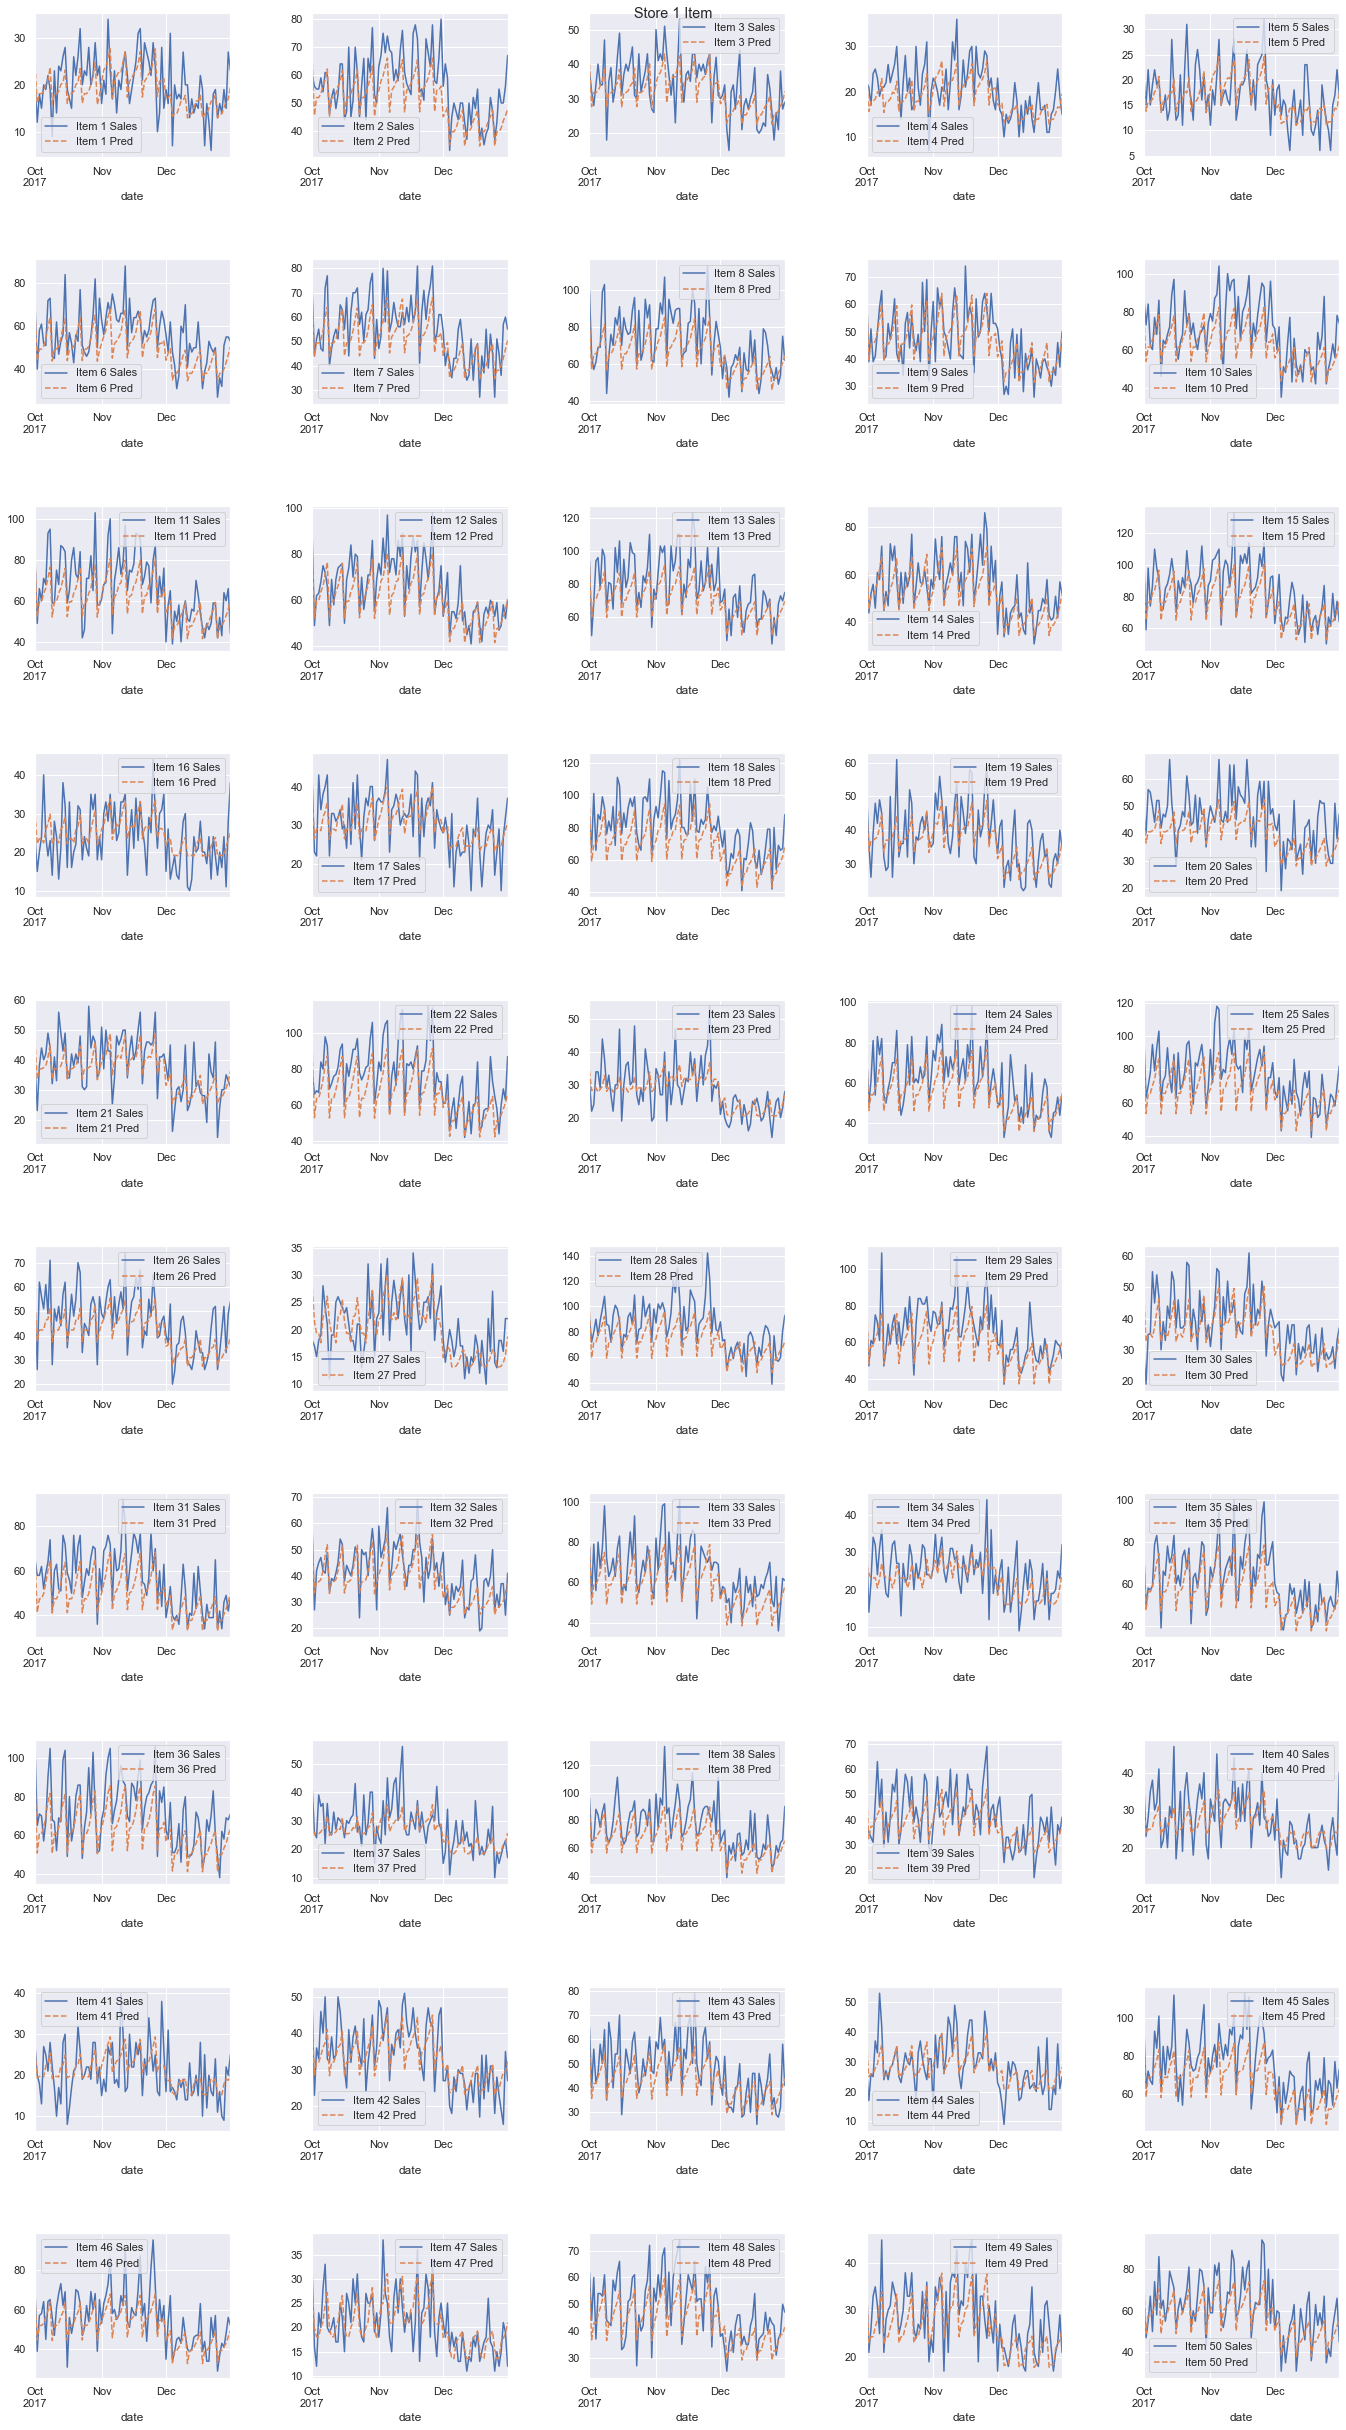

In [57]:
# Store 1 Actual - Pred
sub = error[error.store == 1].set_index("date")
fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].actual.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[0, i - 1], legend=True, label="Item " + str(i) + " Pred", linestyle = "dashed")
    if i >= 6 and i<11:
        sub[sub.item == i].actual.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[1, i - 6], legend=True, label="Item " + str(i) + " Pred",  linestyle="dashed")
    if i >= 11 and i<16:
        sub[sub.item == i].actual.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[2, i - 11], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 16 and i<21:
        sub[sub.item == i].actual.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[3, i - 16], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 21 and i<26:
        sub[sub.item == i].actual.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[4, i - 21], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 26 and i<31:
        sub[sub.item == i].actual.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[5, i - 26], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 31 and i<36:
        sub[sub.item == i].actual.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[6, i - 31], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 36 and i<41:
        sub[sub.item == i].actual.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[7, i - 36], legend=True, label="Item " + str(i) + " Pred", linestyle="dashed")
    if i >= 41 and i<46:
        sub[sub.item == i].actual.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[8, i - 41], legend=True, label="Item " + str(i) + " Pred",linestyle="dashed")
    if i >= 46 and i<51:
        sub[sub.item == i].actual.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales")
        sub[sub.item == i].pred.plot(ax=axes[9, i - 46], legend=True, label="Item " + str(i) + " Pred",linestyle="dashed")
plt.tight_layout(pad=4.5)
plt.suptitle("Store 1 Item");
plt.show()

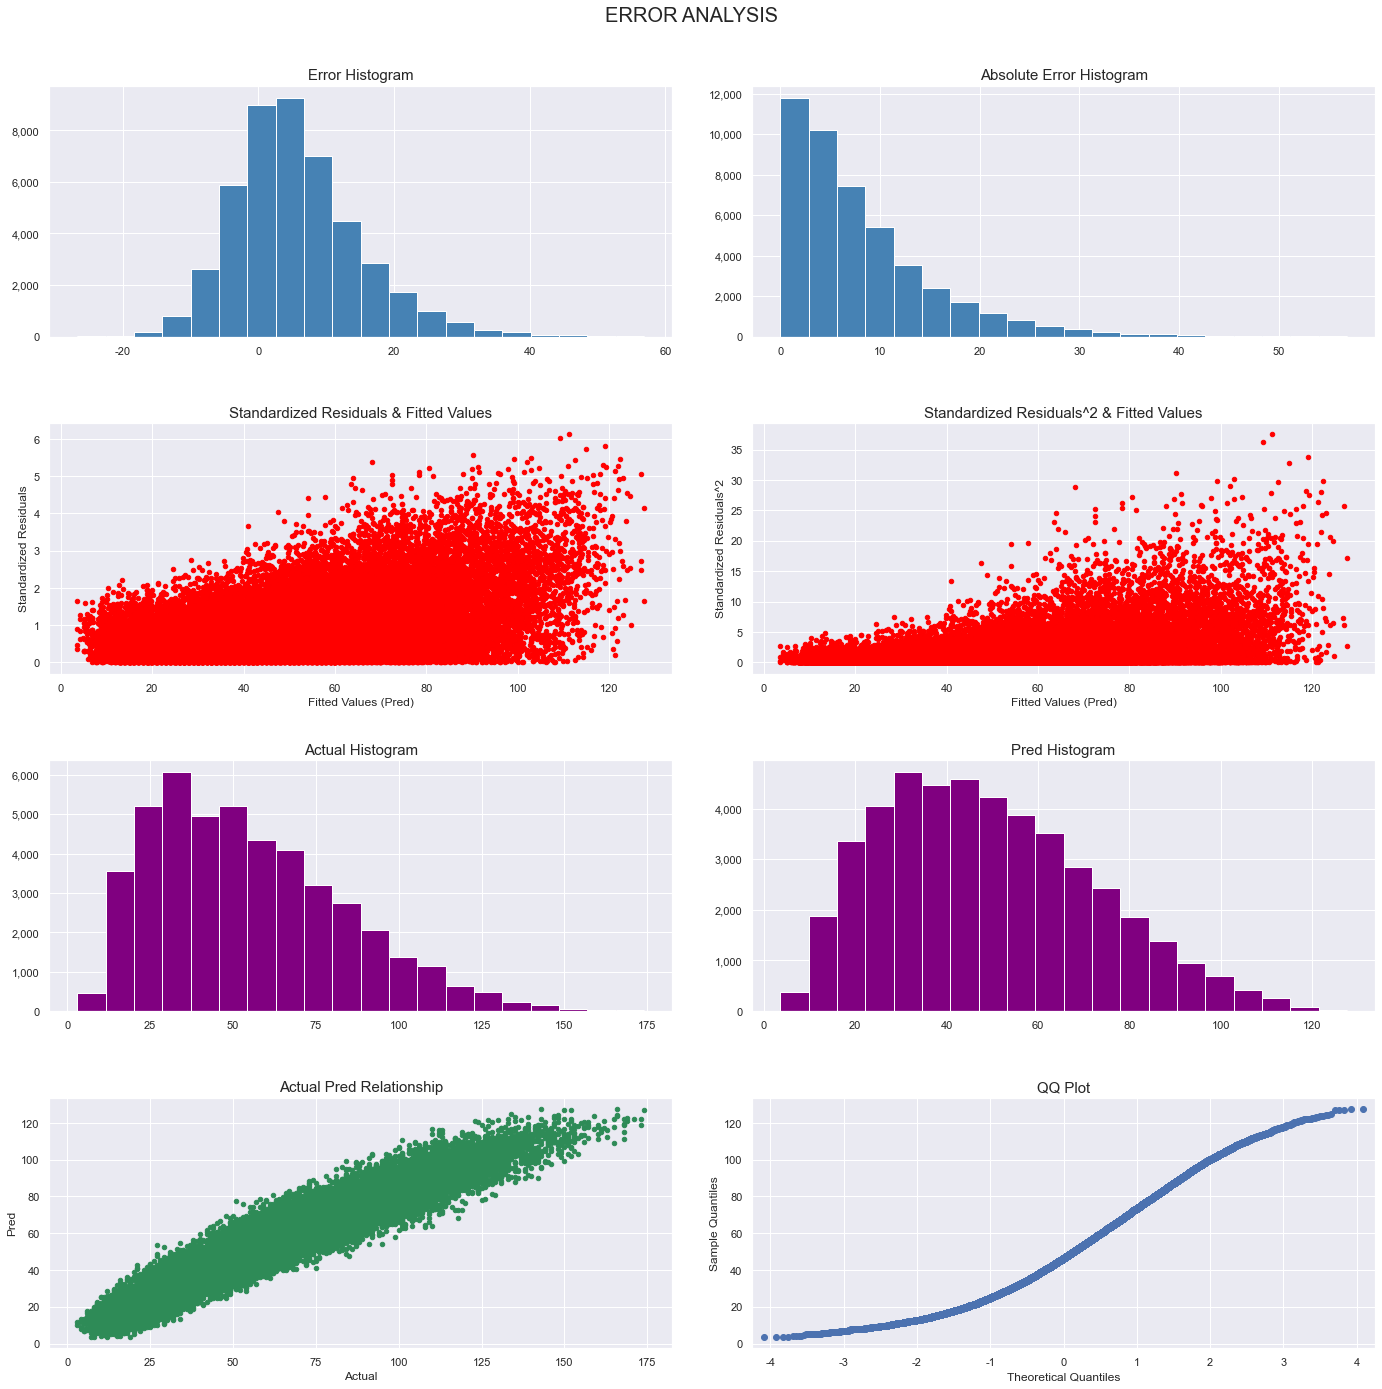

In [58]:
fig, axes = plt.subplots(4, 2, figsize = (20,20))
for axi in axes.flat:
    axi.ticklabel_format(style="sci", axis="y", scilimits=(0,10))
    axi.ticklabel_format(style="sci", axis="x", scilimits=(0,10))
    axi.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    axi.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
(error.actual-error.pred).hist(ax = axes[0, 0], color = "steelblue", bins = 20)
error.error.hist(ax = axes[0,1], color = "steelblue", bins = 20)
sr = error.copy()
sr["StandardizedR"] = (sr.error / (sr.actual-sr.pred).std())
sr["StandardizedR2"] = ((sr.error / (sr.actual-sr.pred).std())**2)
sr.plot.scatter(x = "pred",y = "StandardizedR", color = "red", ax = axes[1,0])
sr.plot.scatter(x = "pred",y = "StandardizedR2", color = "red", ax = axes[1,1])
error.actual.hist(ax = axes[2, 0], color = "purple", bins = 20)
error.pred.hist(ax = axes[2, 1], color = "purple", bins = 20)
error.plot.scatter(x = "actual",y = "pred", color = "seagreen", ax = axes[3,0]);
# QQ Plot
import statsmodels.api as sm
import pylab
sm.qqplot(sr.pred, ax = axes[3,1], c = "seagreen")
plt.suptitle("ERROR ANALYSIS", fontsize = 20)
axes[0,0].set_title("Error Histogram", fontsize = 15)
axes[0,1].set_title("Absolute Error Histogram", fontsize = 15)
axes[1,0].set_title("Standardized Residuals & Fitted Values", fontsize = 15)
axes[1,1].set_title("Standardized Residuals^2 & Fitted Values", fontsize = 15)
axes[2,0].set_title("Actual Histogram", fontsize = 15)
axes[2,1].set_title("Pred Histogram", fontsize = 15);
axes[3,0].set_title("Actual Pred Relationship", fontsize = 15);
axes[3,1].set_title("QQ Plot", fontsize = 15);
axes[1,0].set_xlabel("Fitted Values (Pred)", fontsize = 12)
axes[1,1].set_xlabel("Fitted Values (Pred)", fontsize = 12)
axes[3,0].set_xlabel("Actual", fontsize = 12)
axes[1,0].set_ylabel("Standardized Residuals", fontsize = 12)
axes[1,1].set_ylabel("Standardized Residuals^2", fontsize = 12)
axes[3,0].set_ylabel("Pred", fontsize = 12)
fig.tight_layout(pad=3.0)
plt.savefig("errors.png")
plt.show()

In [59]:
train_final = train_df.loc[(train_df["date"] < "2018-01-01"), :]
test_final = train_df.loc[(train_df["date"] >= "2018-01-01"), :]

X_train_final = train_final[cols]
y_train_final = train_final.sales
X_test_final = test_final[cols]

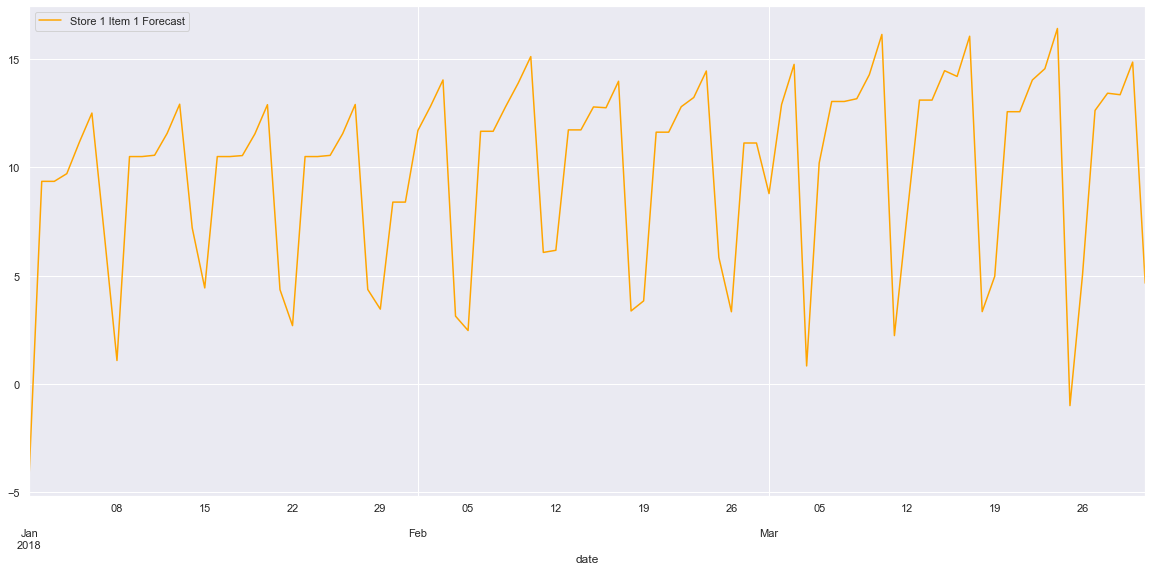

In [60]:
forecast = pd.DataFrame({
    "date":test_final.date,
    "store":test_final.store,
    "item":test_final.item,
    "sales":lgb.predict(X_test_final)
})

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "orange", figsize = (20,9),legend=True, label = "Store 1 Item 1 Forecast");

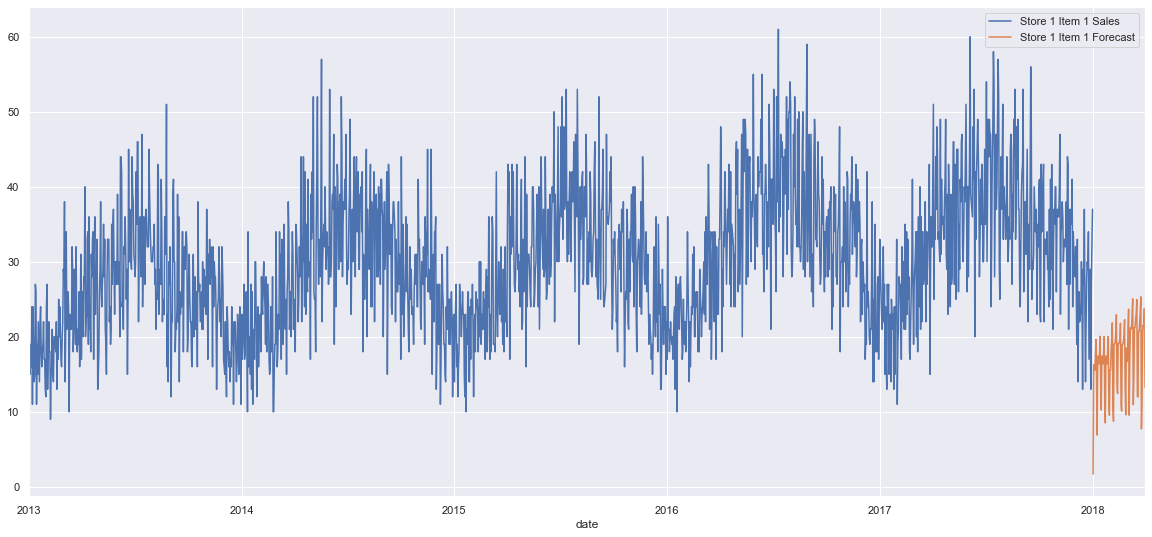

In [61]:
train_final[(train_final.store == 1) & (train_final.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 1 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 1 Forecast");

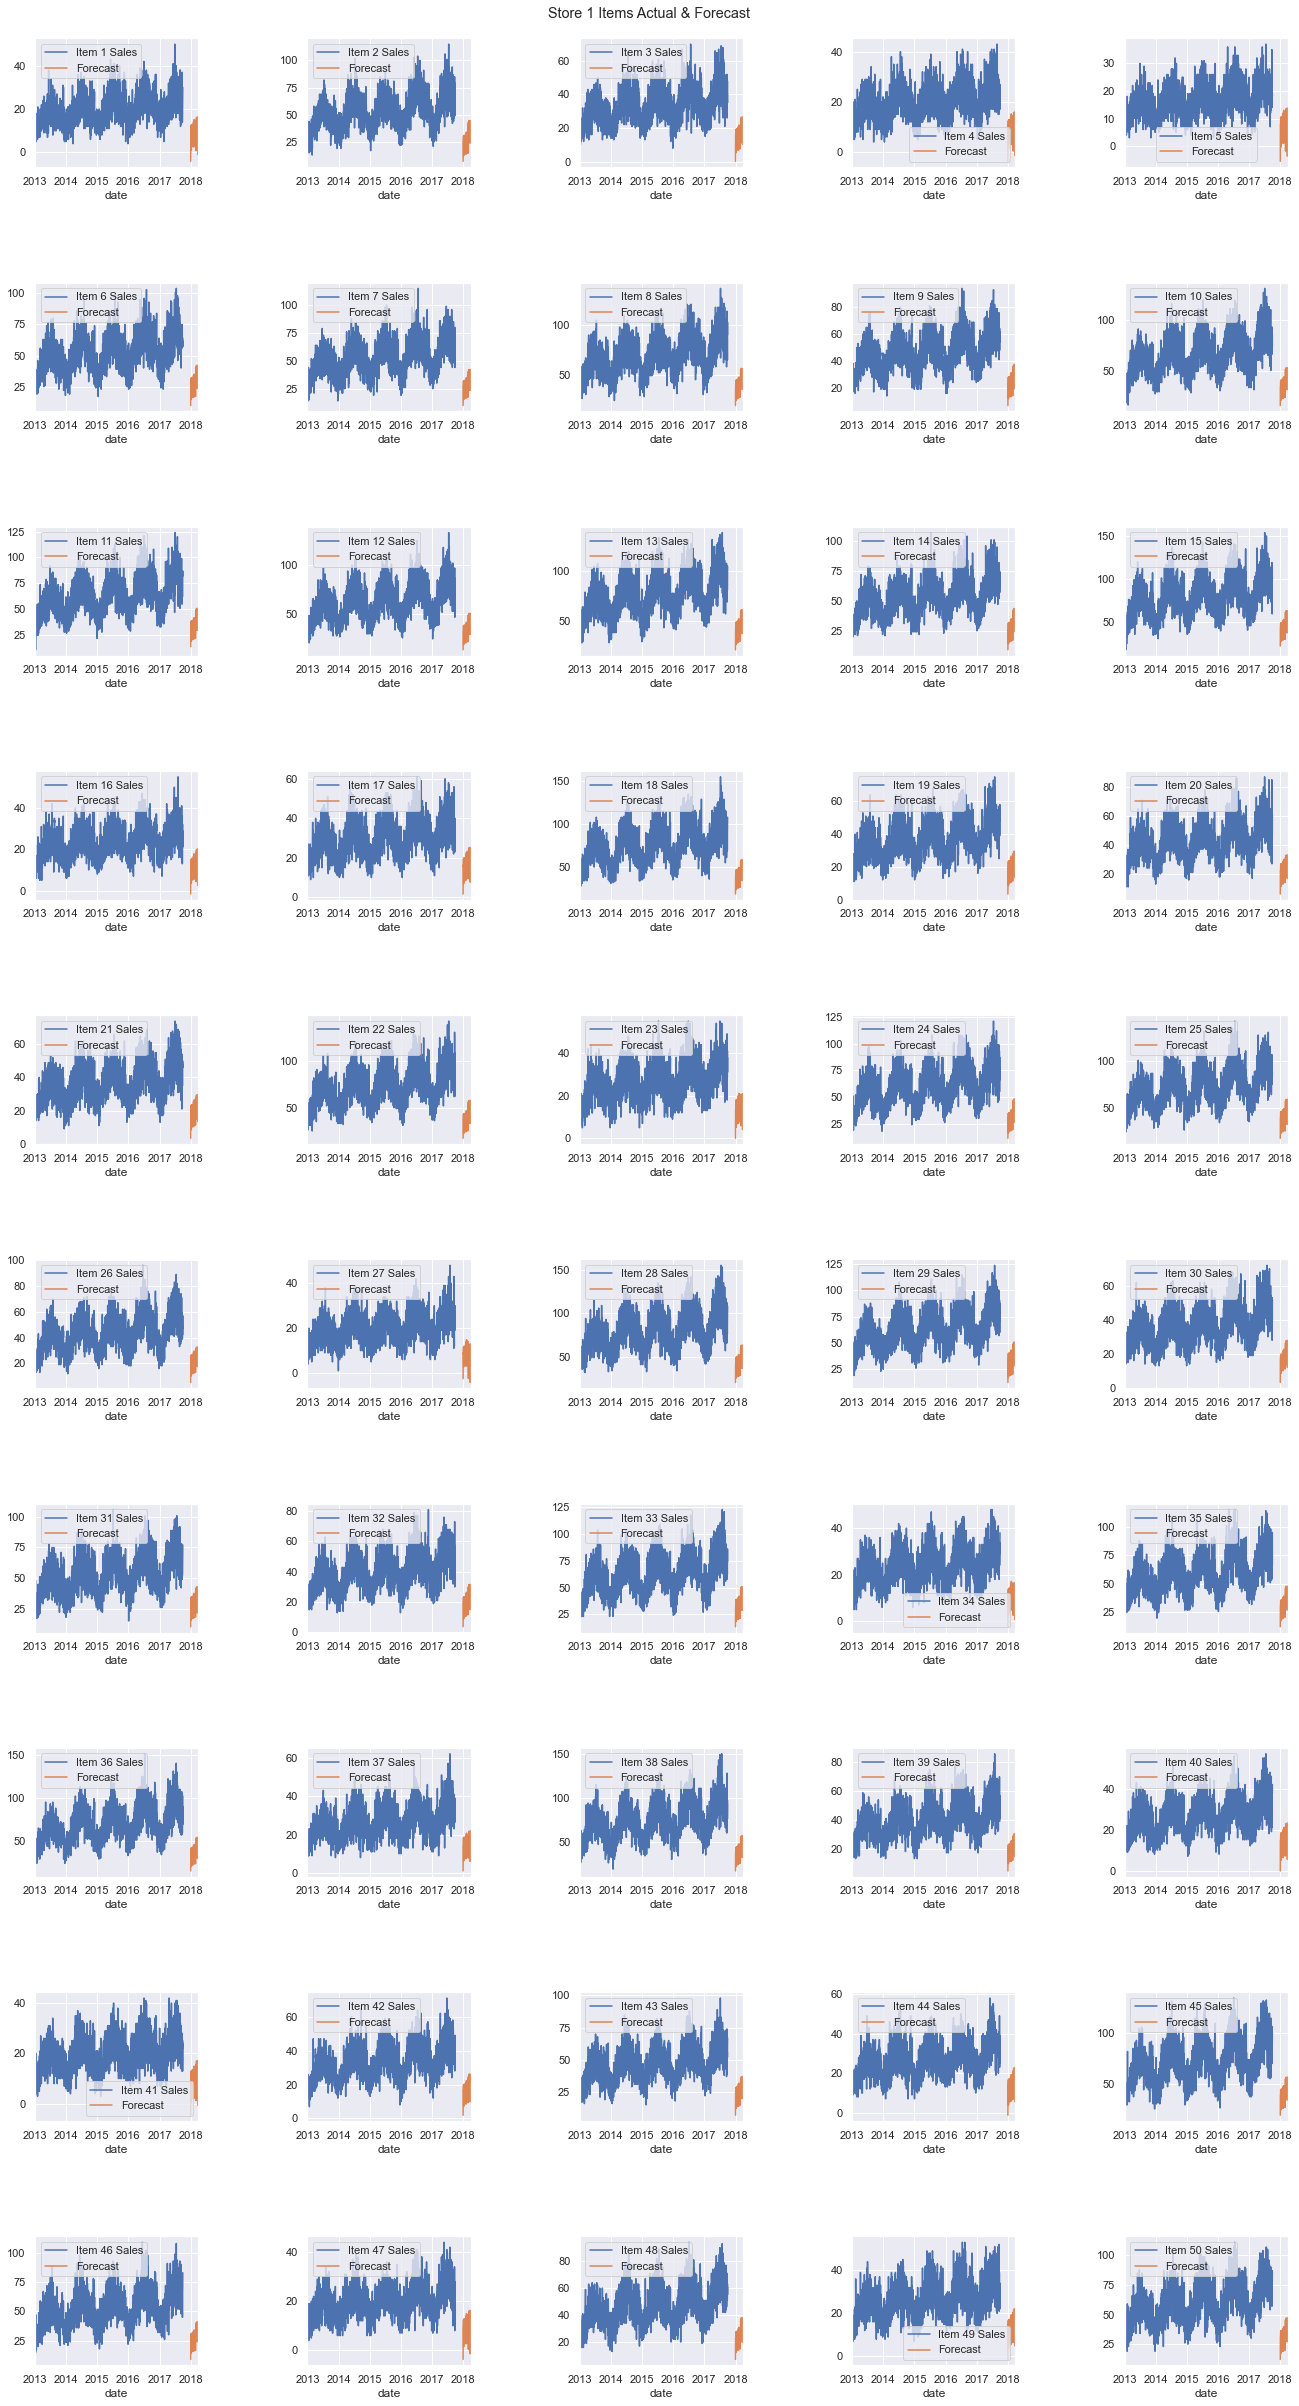

In [62]:
store = 1
sub = train[train.store == store].set_index("date")
forc = forecast[forecast.store == store].set_index("date")


fig, axes = plt.subplots(10, 5, figsize=(20, 35))
for i in range(1,51):
    if i < 6:
        sub[sub.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[0, i-1], legend=True, label = "Forecast")
    if i >= 6 and i<11:
        sub[sub.item == i].sales.plot(ax=axes[1, i - 6], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[1, i-6], legend=True, label = "Forecast")
    if i >= 11 and i<16:
        sub[sub.item == i].sales.plot(ax=axes[2, i - 11], legend=True, label = "Item "+str(i)+" Sales") 
        forc[forc.item == i].sales.plot(ax=axes[2, i-11], legend=True, label = "Forecast")
    if i >= 16 and i<21:
        sub[sub.item == i].sales.plot(ax=axes[3, i - 16], legend=True, label = "Item "+str(i)+" Sales")    
        forc[forc.item == i].sales.plot(ax=axes[3, i-16], legend=True, label = "Forecast")
    if i >= 21 and i<26:
        sub[sub.item == i].sales.plot(ax=axes[4, i - 21], legend=True, label = "Item "+str(i)+" Sales") 
        forc[forc.item == i].sales.plot(ax=axes[4, i-21], legend=True, label = "Forecast")
    if i >= 26 and i<31:
        sub[sub.item == i].sales.plot(ax=axes[5, i - 26], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[5, i-26], legend=True, label = "Forecast")
    if i >= 31 and i<36:
        sub[sub.item == i].sales.plot(ax=axes[6, i - 31], legend=True, label = "Item "+str(i)+" Sales")  
        forc[forc.item == i].sales.plot(ax=axes[6, i-31], legend=True, label = "Forecast")
    if i >= 36 and i<41:
        sub[sub.item == i].sales.plot(ax=axes[7, i - 36], legend=True, label = "Item "+str(i)+" Sales")
        forc[forc.item == i].sales.plot(ax=axes[7, i-36], legend=True, label = "Forecast")
    if i >= 41 and i<46:
        sub[sub.item == i].sales.plot(ax=axes[8, i - 41], legend=True, label = "Item "+str(i)+" Sales") 
        forc[forc.item == i].sales.plot(ax=axes[8, i-41], legend=True, label = "Forecast")
    if i >= 46 and i<51:
        sub[sub.item == i].sales.plot(ax=axes[9, i - 46], legend=True, label = "Item "+str(i)+" Sales") 
        forc[forc.item == i].sales.plot(ax=axes[9, i-46], legend=True, label = "Forecast")
plt.tight_layout(pad=6.5)
plt.suptitle("Store 1 Items Actual & Forecast");

In [66]:
forecast.head(40)

,date,store,item,sales
0,2018-01-01,1,1,-4.117798
1,2018-01-02,1,1,9.346882
2,2018-01-03,1,1,9.346882
3,2018-01-04,1,1,9.702665
4,2018-01-05,1,1,11.151474
5,2018-01-06,1,1,12.496773
6,2018-01-07,1,1,6.854337
7,2018-01-08,1,1,1.083737
8,2018-01-09,1,1,10.490205
9,2018-01-10,1,1,10.490205
